In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [2]:
master_url_root= "https://raw.githubusercontent.com/numenta/NAB/master/data/"

In [3]:
df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(df_small_noise_url, parse_dates=True, index_col="timestamp")
df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(df_daily_jumpsup_url, parse_dates=True, index_col="timestamp")

In [4]:
print(df_small_noise.head())
print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


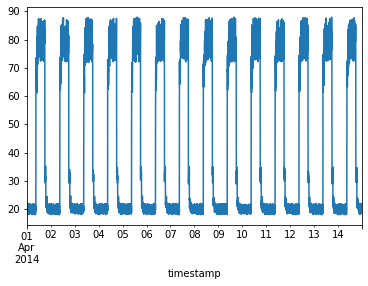

In [5]:
fig,ax=plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

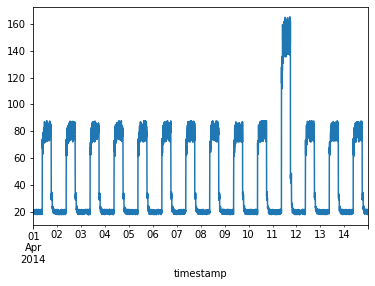

In [6]:
fig, ax= plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

In [7]:
#Normalize and save te mean and std, we get
# for normalizing test data

training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean)/training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


In [8]:
TIME_STEPS = 288

#Generated training sequences for use in the model

def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values)-time_steps+1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)


# Build a MODEL


In [9]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

In [10]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 4s 95ms/step - loss: 0.4932 - val_loss: 0.0933
Epoch 2/50
27/27 [==============================] - 2s 56ms/step - loss: 0.0797 - val_loss: 0.0419
Epoch 3/50
27/27 [==============================] - 1s 51ms/step - loss: 0.0571 - val_loss: 0.0363
Epoch 4/50
27/27 [==============================] - 2s 71ms/step - loss: 0.0484 - val_loss: 0.0302
Epoch 5/50
27/27 [==============================] - 2s 62ms/step - loss: 0.0415 - val_loss: 0.0258
Epoch 6/50
27/27 [==============================] - 2s 61ms/step - loss: 0.0365 - val_loss: 0.0235
Epoch 7/50
27/27 [==============================] - 2s 86ms/step - loss: 0.0324 - val_loss: 0.0212
Epoch 8/50
27/27 [==============================] - 1s 49ms/step - loss: 0.0296 - val_loss: 0.0188
Epoch 9/50
27/27 [==============================] - 2s 81ms/step - loss: 0.0274 - val_loss: 0.0183
Epoch 10/50
27/27 [==============================] - 2s 62ms/step - loss: 0.0256 - val_loss: 0.0160
Epoch 11/

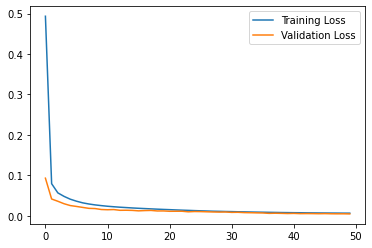

In [11]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

# We will detect anomalies by determining how well our model can reconstruct the input data.

1.Find Mean Absolute Error (MAE) loss on training samples.
2. Find max MAE loss value. This is the worst our model has performed trying to reconstruct a sample. We will make this the threshold for anomaly detection.
3. If the reconstruction loss for a sample is greater than this threshold value then we can infer that the model is seeing a    pattern that it isn't familiar with. We will label this sample as an anomaly.

118/118 [==============================] - 1s 5ms/step


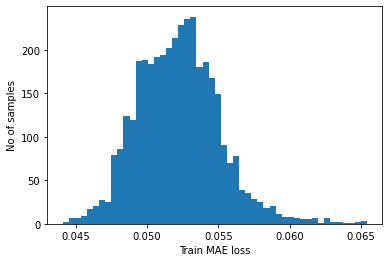

Reconstruction error threshold:  0.06540650307963837


In [12]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

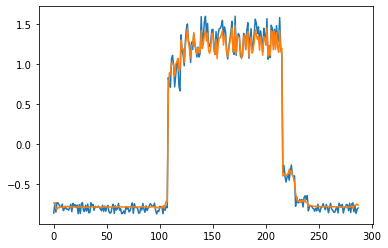

In [13]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

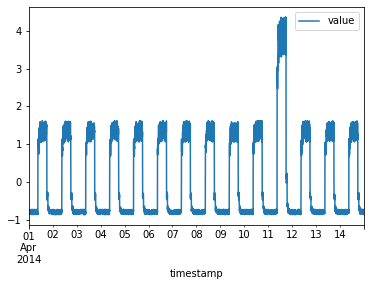

Test input shape:  (3745, 288, 1)
118/118 [==============================] - 1s 5ms/step


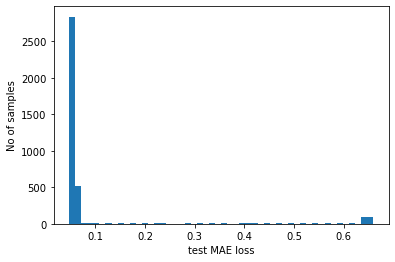

Number of anomaly samples:  422
Indices of anomaly samples:  (array([ 775,  787,  790,  791,  792,  793,  794,  795,  971,  973,  974,
        975, 1657, 1659, 1839, 1944, 1947, 2127, 2519, 2521, 2522, 2523,
       2697, 2698, 2699, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708,
       2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719,
       2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730,
       2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741,
       2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752,
       2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763,
       2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774,
       2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785,
       2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796,
       2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807,
       2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2

In [14]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=True, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

# Plot anomalies
We now know the samples of the data which are anomalies. With this, we will find the corresponding timestamps from the original test data. We will be using the following method to do that:

Let's say time_steps = 3 and we have 10 training values. Our x_train will look like this:

0, 1, 2
1, 2, 3
2, 3, 4
3, 4, 5
4, 5, 6
5, 6, 7
6, 7, 8
7, 8, 9
All except the initial and the final time_steps-1 data values, will appear in time_steps number of samples. So, if we know that the samples [(3, 4, 5), (4, 5, 6), (5, 6, 7)] are anomalies, we can say that the data point 5 is an anomaly.

In [15]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

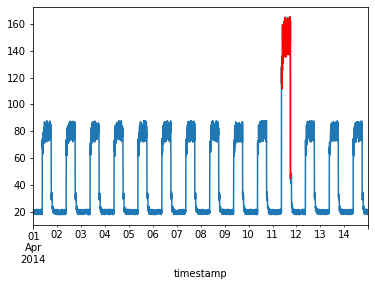

In [16]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()